# Tutorial Multi-Pitch Estimation (MPE) based on HCQT/Conv2D/U-Net

- date: 2024-10-22
- author: geoffroy.peeters@telecom-paris.fr

This notebook was created for the tutorial held at ISMIR-2024 "Deep-Learning 101 for Audio-based Music Information Retrieval".
If you use this notebook, please cite
```
@book{deeplearning-101-audiomir:book,
	author = {Peeters, Geoffroy and Meseguer-Brocal, Gabriel and Riou, Alain and Lattner, Stefan},
	title = {Deep Learning 101 for Audio-based MIR, ISMIR 2024 Tutorial},
	url = {https://geoffroypeeters.github.io/deeplearning-101-audiomir_book},
	address = {San Francisco, USA},
	year = {2024},
	month = November,
	doi = {10.5281/zenodo.14049461},
}
```

It illustrates the use of various deep-learning bricks to solve the task of "Multi-Pitch-Estimation".


Part of the code is based https://github.com/rabitt/ismir-2021-tutorial-case-studies/tree/main/pitch_tracking for "Deep Salience" model.
Datasets are available at https://github.com/flippy-fyp/Bach10_v1.1 for Bach10 and at https://adasp.telecom-paris.fr/resources/2010-07-08-maps-database/ for MAPS.

The two datasets illustrate different type of annotations.
- Bach10 annotates the pitch as the four (one for each stem) fundamental frequencies existing a each time-frame (frame analysis)
- MAPS annotates the pitch as the [start,end,midi-note] of each note (the polyphony varies over time) of the piano performances.

## Deployment

In case the notebook is run on GoogleColab or others, we first need to
- get the packages: `git clone``
- get the datasets

We also test the models on two different datasets:
- Bach10
- MAPS

In [165]:
do_deploy = False

if do_deploy:
    !git clone https://github.com/geoffroypeeters/deeplearning-101-audiomir_notebook.git
    %cd deeplearning-101-audiomir_notebook
    !ls

    import urllib.request
    import shutil
    ROOT = 'https://perso.telecom-paristech.fr/gpeeters/tuto_DL101forMIR/'
    
    #hdf5_audio_file, pyjama_annot_file = 'bach10_audio.hdf5.zip', 'bach10.pyjama'
    hdf5_audio_file, file_annot = 'maps_audio.hdf5.zip', 'maps.pyjama'
    
    urllib.request.urlretrieve(ROOT + hdf5_audio_file, hdf5_audio_file)
    if hdf5_audio_file.endswith('.zip'): shutil.unpack_archive(hdf5_audio_file, './')
    urllib.request.urlretrieve(ROOT + pyjama_annot_file, pyjama_annot_file)

    ROOT = './'

else:

    ROOT = '/tsi/data_doctorants/gpeeters/_data/'

config_file = 'config_bittner.yaml'
#config_file = 'config_doras.yaml'

do_wandb = False
import pprint as pp
import yaml
from munch import munchify
with open(config_file, 'r') as fid: 
    cfg_dic = yaml.safe_load(fid)
config = munchify(cfg_dic)
pp.pprint(config)



{'dataset': Munch({'base': 'bach10', 'do_f0_annot': 'frame'}),
 'feature': {'bins_per_semitone': 5,
             'fmin': 32.7,
             'h_l': [0.5, 1, 2, 3, 4, 5],
             'hop_length': 512,
             'n_octaves': 6,
             'patch_L_frame': 64,
             'patch_STEP_frame': 32,
             'type': 'hcqt'},
 'model': {'block_l': [{'sequential_l': [{'layer_l': [['BatchNorm2d',
                                                       {'num_features': -1}],
                                                      ['Conv2d',
                                                       {'in_channels': -1,
                                                        'kernel_size': [5, 5],
                                                        'out_channels': 128,
                                                        'padding': 'same',
                                                        'stride': 1}],
                                                      ['Activation', 'ReLU']]},

## Import packages

In [166]:
import torch
from torch import nn
#import torchaudio
from torch.utils.data import Dataset
import torch.optim as optim
import torchsummary

! pip install lightning --quiet
import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

! pip install wandb --quiet
import wandb
from pytorch_lightning.loggers import WandbLogger

import json
import yaml
import h5py
import pprint as pp
from tqdm import tqdm
import datetime
from multiprocessing import Pool
import os


import librosa
import numpy as np
import matplotlib.pyplot as plt
import feature

# -----------------------------
import model_factory 
import importlib
importlib.reload(model_factory) 
importlib.reload(feature) 

from argparse import Namespace
! pip install munch --quiet
from munch import munchify

# -----------------------------
! pip install mir_eval --quiet
import mir_eval

## Set fixed seed for reproducibility

In [167]:
import random
seed = 42
torch.manual_seed(seed)         # For CPU
random.seed(seed)               # For Python's built-in random module
np.random.seed(seed)            # For NumPy
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)          # For current GPU
    torch.cuda.manual_seed_all(seed) 

## Parameters

In [168]:
hdf5_audio_file = f'{ROOT}/{config.dataset.base}_audio.hdf5'
hdf5_feat_file = f'{ROOT}/{config.dataset.base}_feat.hdf5'
pyjama_annot_file = f'{ROOT}/{config.dataset.base}.pyjama'

param_model = Namespace()
param_model.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
param_model.batch_size = 32

param_lightning = Namespace()
param_lightning.max_epochs = 500
param_lightning.patience = 10
param_lightning.dirpath='./_pitch_lighning/'
param_lightning.filename='best_model_pitch'

param_wandb = Namespace()
param_wandb.save_dir = './_pitch_wandb/'
param_wandb.project_name = 'wandb_pitch'


## Dataloader

### Test loading pyjama/hdf5

All the audio data of a dataset are stored in a single [.hdf5](https://docs.h5py.org/) file.
Each `key` corresponds to an entry, a specific audiofile.
Its array contains the audio wavform and the attribute `sr_hz` provides its sampling rate.

All the annotations of a dataset are stored in a single *.pyjama file.
As [JAMS](https://github.com/marl/jams) files, .pyjama files are JSON files.
However, a single .pyjama file can contain the annotations of ALL entries of a dataset.
Its specifications are described here [DOC](https://github.com/geoffroypeeters/pyjama).
The values of the `filepath` field of the .pyjama file correspond to the `key` values of the .hdf5 file.


In [169]:
with open(pyjama_annot_file, encoding = "utf-8") as json_fid:
    data_d = json.load(json_fid)
entry_l = data_d['collection']['entry']

if config.dataset.do_f0_annot == 'frame':      pp.pprint(np.asarray(entry_l[4]['f0multi'][0]['value'])[:,20:25])
elif config.dataset.do_f0_annot == 'segment':  pp.pprint(entry_l[4]['pitchmidi'][:5])


# --- get list of audio files
audiofile_l = [entry['filepath'][0]['value'] for entry in entry_l]
print(f'number of audio: {len(audiofile_l)}')
# --- example of audio (for illustration)
pp.pprint(audiofile_l[:5])


with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    pp.pprint(f"audio shape: {hdf5_fid[audiofile_l[0]][:].shape}")
    pp.pprint(f"audio sample-rate: {hdf5_fid[audiofile_l[0]].attrs['sr_hz']}")
    #pp.pprint(hdf5_fid['/'].keys())

array([[72.00969708, 72.00969708, 72.00763743, 72.00763743, 72.00763743],
       [67.31980606, 67.33111726, 67.33111726, 67.32599456, 67.32599456],
       [63.06300285, 63.53039887, 63.76604453, 63.76804668, 63.89703867],
       [57.56662176, 57.56662176, 57.56662176, 63.58919087, 63.58919087]])
number of audio: 50
['01-AchGottundHerr-violin.wav',
 '01-AchGottundHerr-clarinet.wav',
 '01-AchGottundHerr-saxphone.wav',
 '01-AchGottundHerr-bassoon.wav',
 '01-AchGottundHerr.wav']
'audio shape: (556248,)'
'audio sample-rate: 22050'


### Define features

We define the feature that will be used as input to the model, the `X`, and test it on an audio file.
We will use here either the CQT or Harmonic-CQT provided by the function `feature.f_get_hcqt`.

In [170]:
midi_to_f0 = lambda midi: 440*2**((midi-69)/12)
f0_to_midi = lambda f0: np.log2(f0/440)*12+69
flog = lambda x: np.log(1+1000*x)-np.log(1+1000)

In [171]:
param_hcqt = Namespace()
param_hcqt.tmp_dir = './_pitch_feature/'

In [172]:
importlib.reload(feature) 

# --- TEST
idx_file = 0
with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    audio_v = hdf5_fid[audiofile_l[idx_file]][:]
    sr_hz = hdf5_fid[audiofile_l[idx_file]].attrs['sr_hz']
CQT_3m, cqt_time_sec_v, cqt_frequency_hz_v = feature.f_get_hcqt(audio_v, sr_hz, config.feature)
print(f'{CQT_3m.shape} {cqt_frequency_hz_v[0], cqt_frequency_hz_v[-1]}')

(6, 360, 1087) (32.7, 2068.762141794541)


#### Batch/parrallel processing of feature extraction

Since CQT or Harmonic-CQT are costly to be computed on the fly, we will pre-compute the features for all files of the dataset.
To speed-up the computation, we will use several CPU in parrallel `multiprocessing.Pool`, each compute the features for a given file, then store the results in a `.npz` file.
We then collect all the `.npz` file in a single `.hdf5` file.

In [173]:
def f_parrallel(audio_file):
    """
    """
    with h5py.File(hdf5_audio_file, 'r') as audio_fid:
        audio_value_v = audio_fid[audio_file][:]
        audio_sr_hz = audio_fid[audio_file].attrs['sr_hz']
        cqt_value_3m, cqt_time_sec_v, cqt_frequency_hz_v = feature.f_get_hcqt(audio_value_v, audio_sr_hz, config.feature)
        if not os.path.exists(param_hcqt.tmp_dir):
            os.makedirs(param_hcqt.tmp_dir)
        np.savez(f"{param_hcqt.tmp_dir}/{audio_file}.npz", cqt_value_3m=cqt_value_3m, cqt_time_sec_v=cqt_time_sec_v, cqt_frequency_hz_v=cqt_frequency_hz_v)

with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    audio_file_l = [audio_file for audio_file in hdf5_fid['/'].keys()]

with Pool(16) as p: 
    p.map(f_parrallel, audio_file_l)

with h5py.File(hdf5_feat_file, 'w') as feat_fid:
    for audio_file in tqdm(audio_file_l):
        data = np.load(f"{param_hcqt.tmp_dir}/{audio_file}.npz")
        feat_fid['/' + audio_file + '/cqt_value_3m/'] = data['cqt_value_3m']
        feat_fid['/' + audio_file + '/cqt_time_sec_v/'] = data['cqt_time_sec_v']
        feat_fid['/' + audio_file + '/cqt_frequency_hz_v/'] = data['cqt_frequency_hz_v']

100%|██████████| 50/50 [00:01<00:00, 33.13it/s]


(6, 360, 1087)


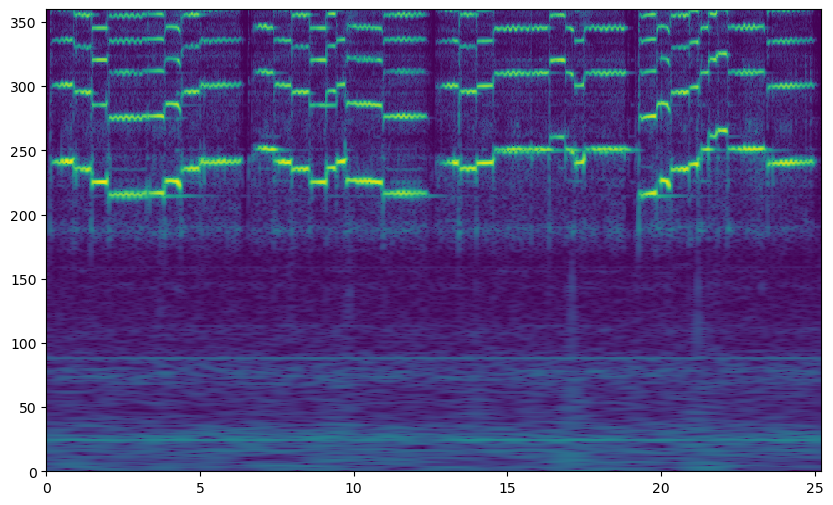

In [174]:
# --- TEST
idx_file = 0
with h5py.File(hdf5_feat_file, 'r') as hdf5_fid:
    cqt_value_3m = hdf5_fid[audiofile_l[idx_file] + '/cqt_value_3m/'][:]
    cqt_time_sec_v = hdf5_fid[audiofile_l[idx_file] + '/cqt_time_sec_v/'][:]
    cqt_frequency_hz_v = hdf5_fid[audiofile_l[idx_file] + '/cqt_frequency_hz_v/'][:]

print(cqt_value_3m.shape)

plt.figure(figsize=(10,6));
plt.imshow(flog(cqt_value_3m[config.feature.h_l.index(1),:,:]), aspect='auto', origin='lower', interpolation='none', extent=[cqt_time_sec_v[0], cqt_time_sec_v[-1], 0, len(cqt_frequency_hz_v)]);
    

#### Defining patches

The input `X` of our model is actually a temporal patch/chunk of the whole feature matrix `(nb_time, nb_dim)`.
For a given feature matrix of length `total_len`, the function `feature.f_get_patches` provides the list of possible patches of length `patch_len` and hop size `patch_hopsize` (we perform frame-analysis over the feature matrix).


In [175]:
# --- TEST
feature.f_get_patches(total_len=250, patch_len=64, patch_hopsize=32)

[{'start_frame': 0, 'end_frame': 64},
 {'start_frame': 32, 'end_frame': 96},
 {'start_frame': 64, 'end_frame': 128},
 {'start_frame': 96, 'end_frame': 160},
 {'start_frame': 128, 'end_frame': 192},
 {'start_frame': 160, 'end_frame': 224}]

### Define mapping

A mapping function is a function that will map the annotations to the format imposed in the `y` of the model and the time extent of the `X`.

Because Bach10 and MAPS use different annotation systems (frame-based or segment-based), we need to write two different mapping functions: `f_map_annot_frame_based` and `f_map_annot_segment_based`.


#### Frame-based f0 annotations

In [176]:
def f_map_annot_frame_based(cqt_time_sec_v, cqt_frequency_hz_v, f0multi_entry_l):
    """
    Map f0 annotations to CQT frames and frequencies in the case the ground-truth is given as frame-based f0

    Args:
        cqt_time_sec_v (nb_frame)
        cqt_frequency_hz_v (nb_freq)
        f0multi_entry_l contains a multi-beakpoint which fields 
            'time' (nb_time)
            'value' (nb_dim, nb_time)
    Returns:
        cqt_f0_value_m (nb_freq, nb_frame)
    """
    
    nb_freq = len(cqt_frequency_hz_v)
    nb_frame = len(cqt_time_sec_v)
    cqt_f0_value_m = np.zeros( (nb_freq, nb_frame) )
    
    gt_time_sec_v = np.asarray(f0multi_entry_l[0]['time'])
    gt_f0_midi_m = np.asarray(f0multi_entry_l[0]['value']) # --- (nb_dim, nb_time)
    nb_stem = gt_f0_midi_m.shape[0]
    
    # --- gt_f0_midi_m (nb_stem, nb_time)
    for num_stem in range(nb_stem):
        for num_frame in range(nb_frame):
            # --- for each time of the CQT we look for the closest ground-truth time
            pos_frame = np.argmin(np.abs(gt_time_sec_v - cqt_time_sec_v[num_frame]))
            # --- we then look for the closest CQT frequency to the ground-truth f0
            gt_f0_hz = midi_to_f0(gt_f0_midi_m[num_stem, pos_frame])
            pos_freq = np.argmin(np.abs(gt_f0_hz-cqt_frequency_hz_v))
            cqt_f0_value_m[pos_freq, num_frame] = 1
    return cqt_f0_value_m

#### Segment-based (start, stop, value) f0 annotations

In [177]:
def f_map_annot_segment_based(cqt_time_sec_v, cqt_frequency_hz_v, segment_l):
    """
    Map f0 annotations to CQT frames and frequencies in the case the ground-truth is given as segment of notes

    Args:
        cqt_time_sec_v (nb_frame)
        cqt_frequency_hz_v (nb_freq)
        segment_l  a list of segments each is a dictionary {'start': , 'stop:', 'value': }
            value is given in midi-float unit
    Returns:
        cqt_f0_value_m (nb_freq, nb_frame)
    """
     
    cqt_f0_value_m = np.zeros( (len(cqt_frequency_hz_v), len(cqt_time_sec_v)) )
    for note_d in segment_l:
        pos_start = np.argmin(np.abs(note_d['time']-cqt_time_sec_v))
        pos_stop = np.argmin(np.abs(note_d['time']+note_d['duration']-cqt_time_sec_v))
        pos_value = np.argmin(np.abs(midi_to_f0(note_d['value'])-cqt_frequency_hz_v))
        cqt_f0_value_m[pos_value,pos_start:pos_stop ] = 1
    return cqt_f0_value_m

01-AchGottundHerr.wav


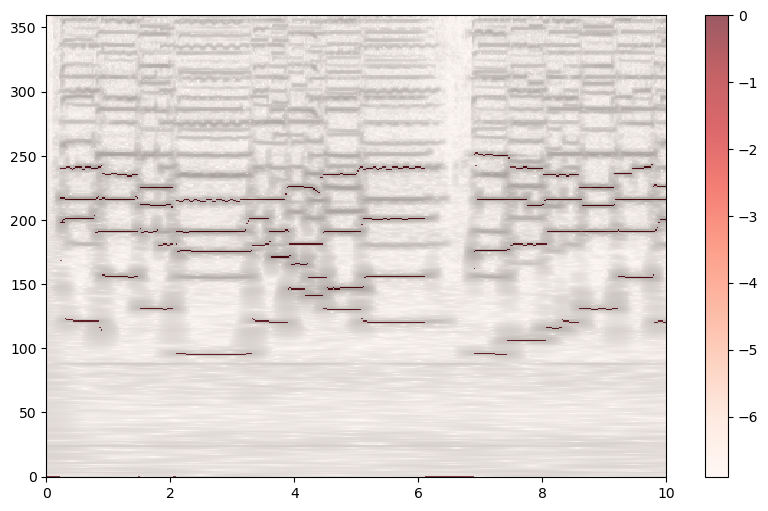

In [178]:
# --- TEST
idx_file = 4
with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    audio_v = hdf5_fid[audiofile_l[idx_file]][:]
    sr_hz = hdf5_fid[audiofile_l[idx_file]].attrs['sr_hz']
entry = data_d['collection']['entry'][idx_file]
print(audiofile_l[idx_file])

cqt_d = Namespace()
cqt_d.value_3m, cqt_d.time_sec_v, cqt_d.frequency_hz_v = feature.f_get_hcqt(audio_v, sr_hz, config.feature)
if config.dataset.do_f0_annot == 'frame':      cqt_d.f0_value_m = f_map_annot_frame_based(cqt_d.time_sec_v, cqt_d.frequency_hz_v, entry['f0multi'])
elif config.dataset.do_f0_annot == 'segment':  cqt_d.f0_value_m = f_map_annot_segment_based(cqt_d.time_sec_v, cqt_d.frequency_hz_v, entry['pitchmidi'])

# -------------------------------
plt.figure(figsize=(10,6));
D=1/2
plt.subplot(111); 
plt.imshow(flog(cqt_d.value_3m[config.feature.h_l.index(1),:,:]), aspect='auto', cmap='gray_r', origin='lower', interpolation='none', extent=[cqt_d.time_sec_v[0], cqt_d.time_sec_v[-1], 0-D, len(cqt_d.frequency_hz_v)-D]);
plt.imshow(flog(cqt_d.f0_value_m), aspect='auto', cmap='Reds', origin='lower', interpolation='none', extent=[cqt_d.time_sec_v[0], cqt_d.time_sec_v[-1], 0-D, len(cqt_d.frequency_hz_v)-D], alpha=0.65);
plt.xlim(0,10)
plt.colorbar();
# -------------------------------

### Create Dataset

The class `PitchDataset` (a subset of pytorch `Dataset` class) is responsible for providing (with the `__getitem` method) the input `X` and ground-truth `y` of the pitches existing in a patch.

- `__getitem__`: for a given `idx_patch`, it provides the `X` (either a patch of CQT or Harmonic-CQT) tensor and the ground-truth binary pitch matrix 
- '__init__': 
  - will read the hdf5_feat_file and pyjama_annot_file
  - split their content according to training and test
  - convert the pitch annotations to the format expected for `y`
  - store all the necessary data in memory (of CPU) to fasten later access: `self.data_d[key=audiofile]` for the CQT/H-CQT, `self.patch_l` for the list of all possible patch over all possibe audiofile. The `__getitem__` method simply get a patch, which audiofile it is coming from, and its position within it. 

In [179]:
from tqdm import tqdm

class PitchDataset(Dataset):
    """
    description
    """

    def __init__(self, hdf5_feat_file, pyjama_annot_file, do_train):

        with open(pyjama_annot_file, encoding = "utf-8") as json_fid: data_d = json.load(json_fid)
        entry_l = data_d['collection']['entry']
        
        # --- only keep entries with annotation field 'f0multi'
        if config.dataset.do_f0_annot == 'frame':
            entry_l = [entry for entry in entry_l if len(entry['f0multi'])]

        self.do_train = do_train
        if self.do_train:   entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) != 0]
        else:               entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) == 0]

        self.data_d = {}
        self.patch_l = []
        
        audio_d = Namespace()
        cqt_d = Namespace()
        gt_d = Namespace()

        with h5py.File(hdf5_feat_file, 'r') as feat_fid:
            for entry in tqdm(entry_l):
                audio_file = entry['filepath'][0]['value']
                
                # --- get features
                cqt_d.value_3m = feat_fid['/' +  audio_file + '/cqt_value_3m/'][:]
                cqt_d.time_sec_v = feat_fid['/' +  audio_file + '/cqt_time_sec_v/'][:]
                cqt_d.frequency_hz_v = feat_fid['/' +  audio_file + '/cqt_frequency_hz_v/'][:]

                # --- map annotations
                if config.dataset.do_f0_annot == 'frame':      cqt_d.f0_value_m = f_map_annot_frame_based(cqt_d.time_sec_v, cqt_d.frequency_hz_v, entry['f0multi'])
                elif config.dataset.do_f0_annot == 'segment':  cqt_d.f0_value_m = f_map_annot_segment_based(cqt_d.time_sec_v, cqt_d.frequency_hz_v, entry['pitchmidi'])


                # --- store for later use
                self.data_d[audio_file] = {'X': torch.tensor(cqt_d.value_3m).float(), 'y': torch.tensor(cqt_d.f0_value_m)}
                
                # --- create list of patches and associate information
                localpatch_l = feature.f_get_patches(cqt_d.value_3m.shape[2], config.feature.patch_L_frame, config.feature.patch_STEP_frame)
                for localpatch in localpatch_l:
                    self.patch_l.append({'audiofile': audio_file,
                                        'start_frame': localpatch['start_frame'],
                                        'end_frame': localpatch['end_frame'],
                                        })
            self.cqt_d_frequency_hz_v = cqt_d.frequency_hz_v
            
    def __len__(self):
        return len(self.patch_l)

    def __getitem__(self, idx_patch):
        audiofile = self.patch_l[idx_patch]['audiofile']
        s = self.patch_l[idx_patch]['start_frame']
        e = self.patch_l[idx_patch]['end_frame']
        
        X = self.data_d[ audiofile ]['X'][:,:, s:e]
        y = self.data_d[ audiofile ]['y'][:, s:e]
        return {'X':X , 'y':y}
    
train_dataset = PitchDataset(hdf5_feat_file, pyjama_annot_file, do_train=True)
valid_dataset = PitchDataset(hdf5_feat_file, pyjama_annot_file, do_train=False)

100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


360
75


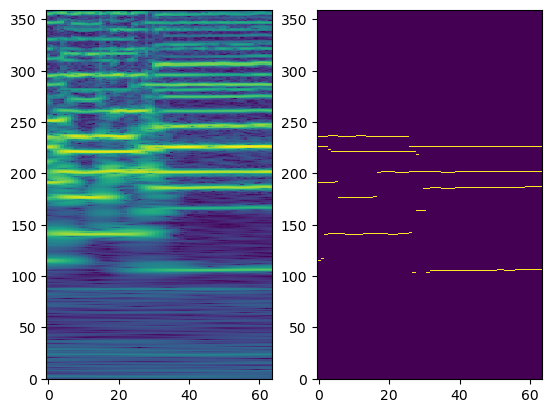

In [180]:
# --- TEST
print(len(train_dataset))
print(len(valid_dataset))

idx_path = 51
plt.subplot(121); plt.imshow(flog(train_dataset[idx_path]['X'][config.feature.h_l.index(1),:,:]).numpy(), aspect='auto', origin='lower', interpolation='none', );
plt.subplot(122); plt.imshow(train_dataset[idx_path]['y'][:,:].numpy(), aspect='auto', origin='lower', interpolation='none', );

### Create DataLoader

We create the dataloader for the training and validation data from the corresponding dataset.


In [181]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=param_model.batch_size, shuffle=True, num_workers=9)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=param_model.batch_size, shuffle=False, num_workers=9)

In [182]:
# --- TEST
batch = next(iter(train_dataloader))
print(batch['X'].size())
print(batch['y'].size())

torch.Size([32, 6, 360, 64])
torch.Size([32, 360, 64])


## Model

The pytorch model is generated automatically based on the content of the `config_bittner.yaml` (ConvNet) or `config_doras.yaml` (U-Net) file.

### ConvNet-model (based on Bittner) or U-Net-model (bsed on Doras)

In [183]:
m, C, H, T = param_model.batch_size, len(config.feature.h_l), 360, config.feature.patch_L_frame
model = model_factory.NetModel(config, [m, C, H, T])
model = model.to(param_model.device)

### Check the model

We can check the model either using
- print(model)
- the `verbose` mode of the `forward` of the model
- the `torchsummary.summary` method

In [184]:
# --- TEST
# #print(model)

X = torch.randn(m, C, H, T).to(param_model.device)
print(model(X, True).size())

#torchsummary.summary(model, (C, H, T))

0/0---------------------------------
Sequential(
  (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (2): ReLU()
)
> in: torch.Size([32, 6, 360, 64])
> out: torch.Size([32, 128, 360, 64])
0/1---------------------------------
Sequential(
  (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ResidualBlock(
    (conv1): Sequential(
      (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_ds): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (relu): ReLU()
  )
)
> in: torch.Size([32, 128, 3

### Test the model

We can also test the model and the loss, i.e. checking that the format of the `X` corresponds to what the model is expected; and the format of the `y` and `hat_y` corresponds to what the loss is expected.
If this is OK we can start training.

In [185]:
batch = next(iter(train_dataloader))
X = batch['X'].to(param_model.device)
y = batch['y'].to(param_model.device)
hat_y = model(X)
print(f'{X.size()} {y.size()} {hat_y.squeeze(1).size()}')


torch.Size([32, 6, 360, 64]) torch.Size([32, 360, 64]) torch.Size([32, 360, 64])


In [186]:
nn.BCEWithLogitsLoss(reduction='none')(hat_y.squeeze(1), y).size()

torch.Size([32, 360, 64])

## Training using torchlighning

### W&B configuration

We configure `https://wandb.ai/` to monitor the training of our model.
As `tensorboard`, `wandb` is a server that keep track of the performance in real-time of a raining. 
Unlike `tensorboard`, `wandb` server runs online and can therefore be accessed from anywhere (you can monitor your training in the bus, train, metro).

In [187]:
if do_wandb:
    train_config_d = {}
    current_datetime = datetime.datetime.now()
    formatted_datetime = current_datetime.strftime("%Y-%m-%d-%H-%M-%S")
    expe_name = formatted_datetime
    wandb.finish()
    wandb_logger = WandbLogger(project = param_wandb.project_name, name = expe_name, save_dir = param_wandb.save_dir )
    wandb_logger.experiment.config.update(train_config_d)

### TorchLightning

In [188]:
class PitchLigthing(pl.LightningModule):
    def __init__(self, in_model):
        super().__init__()
        self.model = in_model
        self.loss = nn.BCEWithLogitsLoss()

    def training_step(self, batch, batch_idx):
        hat_y_prob = self.model(batch['X'])
        loss = self.loss(hat_y_prob.squeeze(1), batch['y'])
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        hat_y_prob = self.model(batch['X'])
        loss = self.loss(hat_y_prob.squeeze(1), batch['y'])
        self.log("valid_loss", loss, prog_bar=True)

        #if batch_idx==0: 
            #data_image = np.hstack( (batch['y'][0,:,:].cpu().numpy(),  nn.Sigmoid()(hat_y_prob[0,0,:,:].detach()).cpu().numpy() ) )
            #wandb.log({'val3/f0': wandb.Image( data_image )})
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), 0.001)
        return optimizer

### Training

We train the model and apply a early-stopping based on the validation loss.

In [189]:
my_lighting = PitchLigthing(model)
early_stop_callback = EarlyStopping(monitor="valid_loss", patience=param_lightning.patience, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='valid_loss', dirpath=param_lightning.dirpath, filename=param_lightning.filename, save_top_k=1, mode='min')
if do_wandb:
    trainer = pl.Trainer(accelerator="gpu",  logger = wandb_logger, max_epochs = param_lightning.max_epochs, callbacks = [early_stop_callback, checkpoint_callback])
else:
    trainer = pl.Trainer(accelerator="gpu",  max_epochs = param_lightning.max_epochs, callbacks = [early_stop_callback, checkpoint_callback])
trainer.fit(model=my_lighting, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | NetModel          | 516 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
516 K     Trainable params
0         Non-trainable params
516 K     Total params
2.065     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 12/12 [00:03<00:00,  3.68it/s, v_num=111, train_loss=0.611, valid_loss=0.476]

Metric valid_loss improved. New best score: 0.476


Epoch 9: 100%|██████████| 12/12 [00:04<00:00,  2.90it/s, v_num=111, train_loss=0.469, valid_loss=0.464]

Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.464


Epoch 10: 100%|██████████| 12/12 [00:04<00:00,  2.96it/s, v_num=111, train_loss=0.450, valid_loss=0.438]

Metric valid_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.438


Epoch 11: 100%|██████████| 12/12 [00:04<00:00,  2.81it/s, v_num=111, train_loss=0.429, valid_loss=0.410]

Metric valid_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.410


Epoch 13: 100%|██████████| 12/12 [00:04<00:00,  2.91it/s, v_num=111, train_loss=0.385, valid_loss=0.387]

Metric valid_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.387


Epoch 14: 100%|██████████| 12/12 [00:04<00:00,  2.86it/s, v_num=111, train_loss=0.363, valid_loss=0.366]

Metric valid_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.366


Epoch 15: 100%|██████████| 12/12 [00:04<00:00,  2.94it/s, v_num=111, train_loss=0.346, valid_loss=0.333]

Metric valid_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.333


Epoch 16: 100%|██████████| 12/12 [00:04<00:00,  2.99it/s, v_num=111, train_loss=0.321, valid_loss=0.294]

Metric valid_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.294


Epoch 18: 100%|██████████| 12/12 [00:04<00:00,  2.94it/s, v_num=111, train_loss=0.282, valid_loss=0.282]

Metric valid_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.282


Epoch 19: 100%|██████████| 12/12 [00:04<00:00,  2.91it/s, v_num=111, train_loss=0.262, valid_loss=0.253]

Metric valid_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.253


Epoch 20: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s, v_num=111, train_loss=0.246, valid_loss=0.238]

Metric valid_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.238


Epoch 22: 100%|██████████| 12/12 [00:04<00:00,  2.95it/s, v_num=111, train_loss=0.225, valid_loss=0.232]

Metric valid_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.232


Epoch 23: 100%|██████████| 12/12 [00:03<00:00,  3.03it/s, v_num=111, train_loss=0.208, valid_loss=0.214]

Metric valid_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.214


Epoch 24: 100%|██████████| 12/12 [00:04<00:00,  2.86it/s, v_num=111, train_loss=0.192, valid_loss=0.187]

Metric valid_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.187


Epoch 25: 100%|██████████| 12/12 [00:04<00:00,  2.92it/s, v_num=111, train_loss=0.178, valid_loss=0.179]

Metric valid_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.179


Epoch 26: 100%|██████████| 12/12 [00:04<00:00,  2.94it/s, v_num=111, train_loss=0.165, valid_loss=0.164]

Metric valid_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.164


Epoch 27: 100%|██████████| 12/12 [00:04<00:00,  2.94it/s, v_num=111, train_loss=0.153, valid_loss=0.153]

Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.153


Epoch 28: 100%|██████████| 12/12 [00:04<00:00,  2.87it/s, v_num=111, train_loss=0.144, valid_loss=0.143]

Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.143


Epoch 29: 100%|██████████| 12/12 [00:04<00:00,  2.93it/s, v_num=111, train_loss=0.134, valid_loss=0.135]

Metric valid_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.135


Epoch 30: 100%|██████████| 12/12 [00:04<00:00,  2.86it/s, v_num=111, train_loss=0.125, valid_loss=0.127]

Metric valid_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.127


Epoch 31: 100%|██████████| 12/12 [00:04<00:00,  2.89it/s, v_num=111, train_loss=0.117, valid_loss=0.116]

Metric valid_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.116


Epoch 32: 100%|██████████| 12/12 [00:04<00:00,  2.94it/s, v_num=111, train_loss=0.110, valid_loss=0.111]

Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.111


Epoch 33: 100%|██████████| 12/12 [00:04<00:00,  2.89it/s, v_num=111, train_loss=0.102, valid_loss=0.103]

Metric valid_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.103


Epoch 34: 100%|██████████| 12/12 [00:04<00:00,  2.90it/s, v_num=111, train_loss=0.0962, valid_loss=0.0979]

Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.098


Epoch 35: 100%|██████████| 12/12 [00:04<00:00,  2.89it/s, v_num=111, train_loss=0.0917, valid_loss=0.0902]

Metric valid_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.090


Epoch 36: 100%|██████████| 12/12 [00:04<00:00,  2.94it/s, v_num=111, train_loss=0.0857, valid_loss=0.0868]

Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.087


Epoch 37: 100%|██████████| 12/12 [00:04<00:00,  2.90it/s, v_num=111, train_loss=0.0813, valid_loss=0.0836]

Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.084


Epoch 38: 100%|██████████| 12/12 [00:04<00:00,  2.87it/s, v_num=111, train_loss=0.0765, valid_loss=0.0764]

Metric valid_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.076


Epoch 39: 100%|██████████| 12/12 [00:04<00:00,  2.92it/s, v_num=111, train_loss=0.0718, valid_loss=0.0712]

Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.071


Epoch 40: 100%|██████████| 12/12 [00:04<00:00,  2.91it/s, v_num=111, train_loss=0.0693, valid_loss=0.0687]

Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.069


Epoch 41: 100%|██████████| 12/12 [00:04<00:00,  2.97it/s, v_num=111, train_loss=0.0644, valid_loss=0.0661]

Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.066


Epoch 42: 100%|██████████| 12/12 [00:04<00:00,  2.96it/s, v_num=111, train_loss=0.0617, valid_loss=0.0627]

Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.063


Epoch 43: 100%|██████████| 12/12 [00:04<00:00,  2.91it/s, v_num=111, train_loss=0.0593, valid_loss=0.0614]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.061


Epoch 44: 100%|██████████| 12/12 [00:04<00:00,  2.94it/s, v_num=111, train_loss=0.0563, valid_loss=0.0554]

Metric valid_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.055


Epoch 45: 100%|██████████| 12/12 [00:04<00:00,  2.99it/s, v_num=111, train_loss=0.0538, valid_loss=0.0547]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.055


Epoch 46: 100%|██████████| 12/12 [00:04<00:00,  2.90it/s, v_num=111, train_loss=0.0505, valid_loss=0.0524]

Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.052


Epoch 47: 100%|██████████| 12/12 [00:04<00:00,  2.95it/s, v_num=111, train_loss=0.0493, valid_loss=0.050] 

Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.050


Epoch 49: 100%|██████████| 12/12 [00:04<00:00,  2.95it/s, v_num=111, train_loss=0.0451, valid_loss=0.0471]

Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.047


Epoch 50: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s, v_num=111, train_loss=0.0443, valid_loss=0.0449]

Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.045


Epoch 51: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s, v_num=111, train_loss=0.0406, valid_loss=0.0447]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.045


Epoch 52: 100%|██████████| 12/12 [00:04<00:00,  2.95it/s, v_num=111, train_loss=0.0398, valid_loss=0.0423]

Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.042


Epoch 53: 100%|██████████| 12/12 [00:04<00:00,  2.91it/s, v_num=111, train_loss=0.0369, valid_loss=0.042] 

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.042


Epoch 54: 100%|██████████| 12/12 [00:03<00:00,  3.03it/s, v_num=111, train_loss=0.0362, valid_loss=0.0413]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.041


Epoch 55: 100%|██████████| 12/12 [00:04<00:00,  2.89it/s, v_num=111, train_loss=0.0347, valid_loss=0.0392]

Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.039


Epoch 56: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s, v_num=111, train_loss=0.0354, valid_loss=0.0383]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.038


Epoch 57: 100%|██████████| 12/12 [00:04<00:00,  2.89it/s, v_num=111, train_loss=0.0334, valid_loss=0.0363]

Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.036


Epoch 58: 100%|██████████| 12/12 [00:04<00:00,  2.82it/s, v_num=111, train_loss=0.0317, valid_loss=0.035] 

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.035


Epoch 60: 100%|██████████| 12/12 [00:04<00:00,  2.91it/s, v_num=111, train_loss=0.0295, valid_loss=0.0346]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.035


Epoch 62: 100%|██████████| 12/12 [00:04<00:00,  2.94it/s, v_num=111, train_loss=0.0285, valid_loss=0.0315]

Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.031


Epoch 64: 100%|██████████| 12/12 [00:04<00:00,  2.87it/s, v_num=111, train_loss=0.0251, valid_loss=0.0314]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.031


Epoch 65: 100%|██████████| 12/12 [00:04<00:00,  2.84it/s, v_num=111, train_loss=0.0254, valid_loss=0.030] 

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.030


Epoch 69: 100%|██████████| 12/12 [00:04<00:00,  2.84it/s, v_num=111, train_loss=0.0241, valid_loss=0.0284]

Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.028


Epoch 70: 100%|██████████| 12/12 [00:04<00:00,  2.92it/s, v_num=111, train_loss=0.0214, valid_loss=0.0271]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.027


Epoch 76: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s, v_num=111, train_loss=0.0181, valid_loss=0.0259]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.026


Epoch 79: 100%|██████████| 12/12 [00:04<00:00,  2.86it/s, v_num=111, train_loss=0.0176, valid_loss=0.0254]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.025


Epoch 81: 100%|██████████| 12/12 [00:04<00:00,  2.84it/s, v_num=111, train_loss=0.0168, valid_loss=0.0252]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.025


Epoch 83: 100%|██████████| 12/12 [00:04<00:00,  2.97it/s, v_num=111, train_loss=0.0163, valid_loss=0.0244]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.024


Epoch 84: 100%|██████████| 12/12 [00:04<00:00,  2.95it/s, v_num=111, train_loss=0.0175, valid_loss=0.0242]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.024


Epoch 89: 100%|██████████| 12/12 [00:04<00:00,  2.90it/s, v_num=111, train_loss=0.0148, valid_loss=0.024] 

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.024


Epoch 97: 100%|██████████| 12/12 [00:03<00:00,  3.00it/s, v_num=111, train_loss=0.0123, valid_loss=0.0231]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.023


Epoch 107: 100%|██████████| 12/12 [00:04<00:00,  2.91it/s, v_num=111, train_loss=0.00977, valid_loss=0.0258]

Monitored metric valid_loss did not improve in the last 10 records. Best score: 0.023. Signaling Trainer to stop.


Epoch 107: 100%|██████████| 12/12 [00:04<00:00,  2.91it/s, v_num=111, train_loss=0.00977, valid_loss=0.0258]


## Evaluation

We first load the best model obtained during training.

In [195]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")
my_lighting = PitchLigthing.load_from_checkpoint(best_model_path, in_model=model)

print( type(model) )
print( type(my_lighting) )
print( type(my_lighting.model) )

model = my_lighting.model

Best model saved at: /home/ids/gpeeters/proj_tuto-ISMIR2024/code/_pitch_lighning/best_model_pitch-v21.ckpt
<class 'model_factory.NetModel'>
<class '__main__.PitchLigthing'>
<class 'model_factory.NetModel'>


### Illustration

We illustrate the results obtained by the trained model on a given audio.

torch.Size([32, 6, 360, 64]) torch.Size([32, 360, 64]) torch.Size([32, 1, 360, 64])


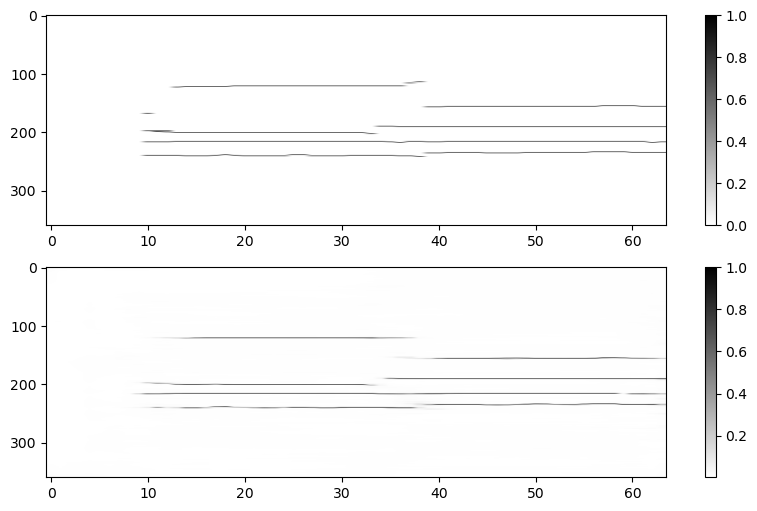

In [196]:
model.to(param_model.device)
data = next(iter(valid_dataloader))

hat_y = nn.Sigmoid()( model(data['X'].to(param_model.device)) )

print(f"{data['X'].size()} {data['y'].size()} {hat_y.size()}")

idx_patch = 0

plt.figure(figsize=(10,6));
plt.subplot(211); plt.imshow(data['y'][idx_patch,:,:].cpu().numpy(), cmap='gray_r', aspect='auto'); plt.colorbar();
plt.subplot(212); plt.imshow(hat_y[idx_patch,0,:,:].detach().cpu().numpy(), cmap='gray_r', aspect='auto'); plt.colorbar();

### Multi-Pitch: performance measures using mir_eval

We send all the data of the validation dataset to the model, get the estimated pitch `hat_y` and change its format t be able to use `mir_eval.multipitch.evaluate`.

In [197]:
import mir_eval
threshold = 0.5

model.to(param_model.device)

store_l = []
for data in valid_dataloader:
    hat_y = nn.Sigmoid()( model(data['X'].to(param_model.device)) )
    
    nb_patch = hat_y.size(0)
    for idx_patch in range(nb_patch):
        gt_m = data['y'][idx_patch,:,:].cpu().numpy()
        est_m = hat_y[idx_patch,0,:,:].detach().cpu().numpy()
        ref_time_l, est_time_l, ref_freqs_l, est_freqs_l = [], [], [], []

        for t in range(gt_m.shape[1]):
            ref_time_l.append( float(t) )
            ref_freqs_l.append( valid_dataset.cqt_d_frequency_hz_v[ gt_m[:,t]>0 ] )
            est_time_l.append( float(t) )
            est_freqs_l.append( valid_dataset.cqt_d_frequency_hz_v[ est_m[:,t]>threshold ] )

        ref_time_l = np.array(ref_time_l)
        est_time_l = np.array(est_time_l)

        dict_d = mir_eval.multipitch.evaluate(ref_time_l, ref_freqs_l, est_time_l, est_freqs_l)
        if len(store_l)==0: key_l = [key for key in dict_d.keys()]
        dict_d['gt_m'] = gt_m
        dict_d['est_m'] = est_m
        store_l.append(dict_d)

for key in key_l: print(f"{key:30}: {np.mean([store[key] for store in store_l])}")

Precision                     : 0.922970419375208
Recall                        : 0.8034939770913823
Accuracy                      : 0.7553731920111368
Substitution Error            : 0.04114885586202697
Miss Error                    : 0.15535716704659067
False Alarm Error             : 0.026535228522341536
Total Error                   : 0.2230412514309592
Chroma Precision              : 0.9474942089031064
Chroma Recall                 : 0.8245809754404899
Chroma Accuracy               : 0.7884549169647406
Chroma Substitution Error     : 0.02006185751291932
Chroma Miss Error             : 0.15535716704659067
Chroma False Alarm Error      : 0.026535228522341536
Chroma Total Error            : 0.20195425308185153


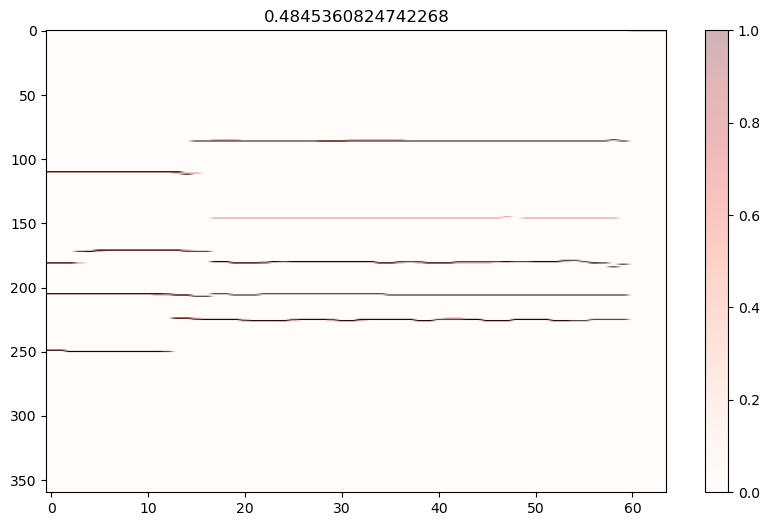

In [198]:
key = 'Accuracy'
pos = np.argmin([store[key] for store in store_l])

plt.figure(figsize=(10,6));
plt.subplot(111); 
plt.imshow(store_l[pos]['gt_m'], cmap='gray_r', aspect='auto'); 
plt.imshow(store_l[pos]['est_m']>0.5, cmap='Reds', aspect='auto', alpha=0.3); 
plt.colorbar()
plt.title(store_l[pos][key]);

In [199]:
print(f'cp {config.output_file.origin} {config.output_file.origin + config.output_file.ext}')

cp TUTO_task_Multi_Pitch_Estimation.ipynb TUTO_task_Multi_Pitch_Estimation.ipynb_D1-I2-C4.ipynb
